In [2]:
from xgboost import XGBClassifier

from training.model_training_xgboost import xgboost_params

model: XGBClassifier = XGBClassifier(**xgboost_params)
model.load_model("../models/xgb_model_1.json")

In [23]:
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, Compose
from torchvision.datasets import ImageFolder
from os import path
from torch.utils.data import DataLoader
from shared import get_extracted_data, BASE_DIR, get_resnext_model

test_dataset = ImageFolder(path.join(BASE_DIR, "test"), transform=Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=True, num_workers=8)

features_test, targets_test = get_extracted_data(test_dataloader, extractor=get_resnext_model())

	⏳Please wait: [█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.7% done
	⏳Please wait: [█░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 1.4% done
	⏳Please wait: [██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 2.2% done
	⏳Please wait: [███░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 2.9% done
	⏳Please wait: [████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 3.6% done
	⏳Please wait: [████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 4.3% done
	⏳Please wait: [█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 5.1% done
	⏳Please wait: [██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

Cohen Kappa quadratic score 0.7963382610497836


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

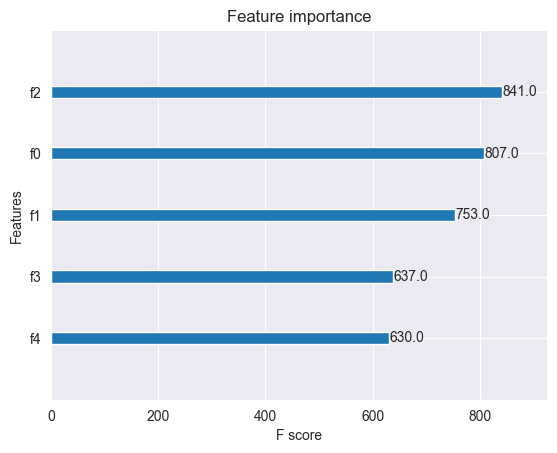

In [24]:
import xgboost
from sklearn.metrics import cohen_kappa_score

prediction = model.predict(features_test)
print("Cohen Kappa quadratic score", cohen_kappa_score(targets_test, prediction, weights="quadratic"))
xgboost.plot_importance(model, max_num_features=12)

Accuracy = 0.6612318840579711


<AxesSubplot: >

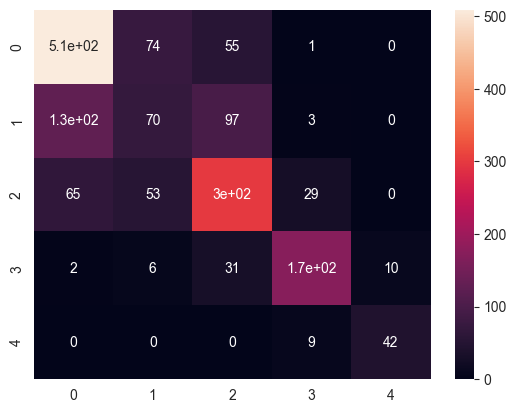

In [25]:
from seaborn import heatmap
from sklearn.metrics import accuracy_score, confusion_matrix

print("Accuracy =", accuracy_score(targets_test, prediction))
cm = confusion_matrix(targets_test, prediction)
heatmap(cm, annot=True)

In [83]:
import numpy as np
from scipy.special import softmax
from shared import training_device, kl_level
from torchvision.datasets.folder import pil_loader


def transform_image(image_path: str):
    my_transforms = Compose([
        Resize(255),
        CenterCrop(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = pil_loader(image_path)
    return my_transforms(img).unsqueeze(0)


def get_prediction(image_path: str):
    tensor = transform_image(image_path)
    tensor = tensor.to(training_device())

    output = get_resnext_model().forward(tensor)

    prediction = model.predict(output.detach().cpu())[0]
    probs = model.predict_proba(output.detach().cpu())

    probs = softmax(probs, axis=1)
    conf = np.max(probs)

    return conf, kl_level[prediction]

Arthrosis [KL = 2] at confidence score: 0.25


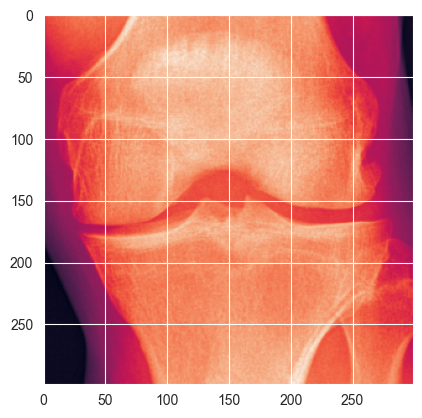

In [84]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from matplotlib import pyplot as plt

root = Tk()
image_path = askopenfilename(title="Pick an knee image",
                             filetypes=[("Images", "*.jpeg"), ("Images", "*.jpg"), ("Images", "*.png")])
root.destroy()

image = plt.imread(image_path)
plt.imshow(image)

conf, y_pre = get_prediction(image_path)
print(y_pre, "at confidence score: {0:.2f}".format(conf))